# Code Examples From Parameter Free Bayesian Density Estimation
Parameter Free Bayesian Density Estimation is a cool paper by P. Richard Hahn (2016) [http://faculty.chicagobooth.edu/richard.hahn/PFBDE.pdf].  This julia notebook implements the examples from that paper. 

In [1]:
using Distributions
using Gadfly;

## Example 1: Predictivist Bayes take on a standard Beta Bernoulli model.

In [2]:
X = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1];

In [3]:
# define the posterior predictive rule for the beta bernoulli in the standard way
PosteriorPredictiveRule1 = function(pastX::Array{Int64})
    α_0 = 1
    β_0 = 1 # define "pseudodata" that will be augmented to any pastX

    if size(pastX,1) > 0
        α_t = α_0 + sum(pastX)
        β_t = β_0 + sum(1 .- pastX)
    else
        α_t = α_0
        β_t = β_0
    end
    
    x_new = rand(Bernoulli(α_t / (α_t + β_t)))
    
    return x_new
end;

In [5]:
# define the terms of the forward simulations
horizon = 1000
nits = 5000;
sims = zeros(Int64,horizon, nits);

In [6]:
# simulate out to the forecast horizon for a number of separate Monte Carlo iterations
for jj = 1:nits
    for ii = 1:horizon
        if ii > 1
            sims[ii,jj] = PosteriorPredictiveRule1(vcat(X,sims[1:(ii-1), jj]))
        else
            sims[ii,jj] = PosteriorPredictiveRule1(X)
        end
    end
end;

In [7]:
# Convert the Bernoulli draws into running means
cumulativesims = cumsum(sims,1)
runningprobs = zeros(Float64, horizon, nits)
sumX = sum(X)
lengthX = size(X,1)
for jj = 1:nits
    for ii = 1:horizon
        runningprobs[ii,jj] = (cumulativesims[ii,jj] + sumX) / (ii + lengthX)
    end
end;

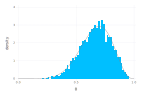

In [8]:
# plot to demonstrate the equivalence of these posterior draws and the analytical Beta(8,4) distribution (Fig 2)
plot(layer(x=runningprobs[horizon,:], Geom.histogram(density=true, bincount=50),order=1),
layer(x=0:.01:1,y=pdf(Beta(8,4),0:0.01:1), Geom.line, Theme(default_color=colorant"grey"),order=2),
Guide.xlabel("θ"), Guide.ylabel("density"))

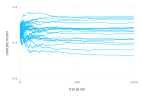

In [9]:
# plot to demonstrate the simulated sample paths for simulations starting with the observed X (black lines of fig 3)
samplepaths = Layer[]
for ii = 1:20
    push!(samplepaths, layer(x=1:horizon, y=runningprobs[:,ii], Geom.line)[1])
end
plot(samplepaths, Guide.xlabel("iteration"), Guide.ylabel("sample mean"), Coord.Cartesian(ymin=0, ymax=1))

End of example the first.